In [1]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning
from scipy.stats import binom_test

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict

from contrastive.evaluation.train_multiple_classifiers import compute_auc

INFO: you cannot use deep_folding in brainvisa. Probably OK.


In [2]:
# test model
test_model = "/neurospin/dico/jchavas/Runs/57_miccai2023_checks_done_after/Output/contrastive/trained_on_UkBioBank/chosen_model/chosen_model"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset_train = 'cingulate_UkBioBank_full'

# load the data
train_df = pd.read_csv(test_model+'/'+dataset_train+'_embeddings/train_val_embeddings.csv', index_col=0)
train_df.sort_index(inplace=True)

In [3]:
dataset_test = 'cingulate_UkBioBank_full'

test_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
test_df.sort_index(inplace=True)

# load the labels
prediction_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
prediction_df.sort_index(inplace=True)
len(prediction_df)

1101

In [4]:
prediction_df.head()

,label,svm_0,svm_1,svm_2,svm_3,svm_4,svm_5,svm_6,svm_7,svm_8,...,svm_243,svm_244,svm_245,svm_246,svm_247,svm_248,svm_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
sub-1000021,0,0.948965,0.948382,0.949156,0.947968,0.949186,0.949133,0.948409,0.949833,0.950552,...,0.949805,0.948885,0.949294,0.949522,0.949724,0.948059,0.950234,0.948938,0.949238,0.951779
sub-1000458,0,0.948968,0.948336,0.949167,0.947927,0.949205,0.949145,0.948385,0.949872,0.950607,...,0.949829,0.948886,0.949311,0.949550,0.949667,0.948016,0.950270,0.948940,0.949237,0.951849
sub-1000575,0,0.948868,0.949761,0.948838,0.949198,0.948585,0.948777,0.949140,0.948641,0.948820,...,0.949047,0.948879,0.948766,0.948677,0.951457,0.949355,0.949115,0.949034,0.949242,0.949573
sub-1000606,0,0.948910,0.949169,0.948976,0.948669,0.948846,0.948931,0.948825,0.949160,0.949577,...,0.949376,0.948882,0.948995,0.949044,0.950714,0.948798,0.949602,0.949012,0.949244,0.950540
sub-1000963,0,0.948995,0.947940,0.949256,0.947575,0.949374,0.949245,0.948177,0.950203,0.951085,...,0.950041,0.948887,0.949459,0.949786,0.949167,0.947644,0.950581,0.948900,0.949231,0.952453


## correlation functions

In [5]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [6]:
def cross_correlation(model_path, dataset='cingulate_ACCpatterns_1'):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    fig, axs = plt.subplots(1, 4, figsize=(30,10)) 

    latent_df = full_df.iloc[:,1:]
    corr = latent_df.corr()
    axs[0] = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[0]
            )

    latent_df = full_df[full_df.label == 0].iloc[:,1:]
    corr0 = latent_df.corr()
    axs[1] = sns.heatmap(
            corr0, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[1]
            )

    latent_df = full_df[full_df.label == 1].iloc[:,1:]
    corr1 = latent_df.corr()
    axs[2] = sns.heatmap(
            corr1, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[2]
            )

    corrdiff = (corr1-corr0)
    axs[3] = sns.heatmap(
            corrdiff, 
            vmin=corrdiff.min().min(), vmax=corrdiff.max().max(), center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[3]
            )


In [7]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False, dataset='cingulate_ACCpatterns_1'):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(16,12))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

In [8]:
def full_visualization(model_path, dataset='cingulate_ACCpatterns_1'):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/"+dataset+"_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    return visualize_umaps(model_path, dataset)

In [9]:
# test model
# visual_embs = full_visualization(test_model)

## Visualize each variable of the latent

x, full_df and colors shapes:  (171, 10) (171, 11) (171, 10)
(10,) (10,) (10,)


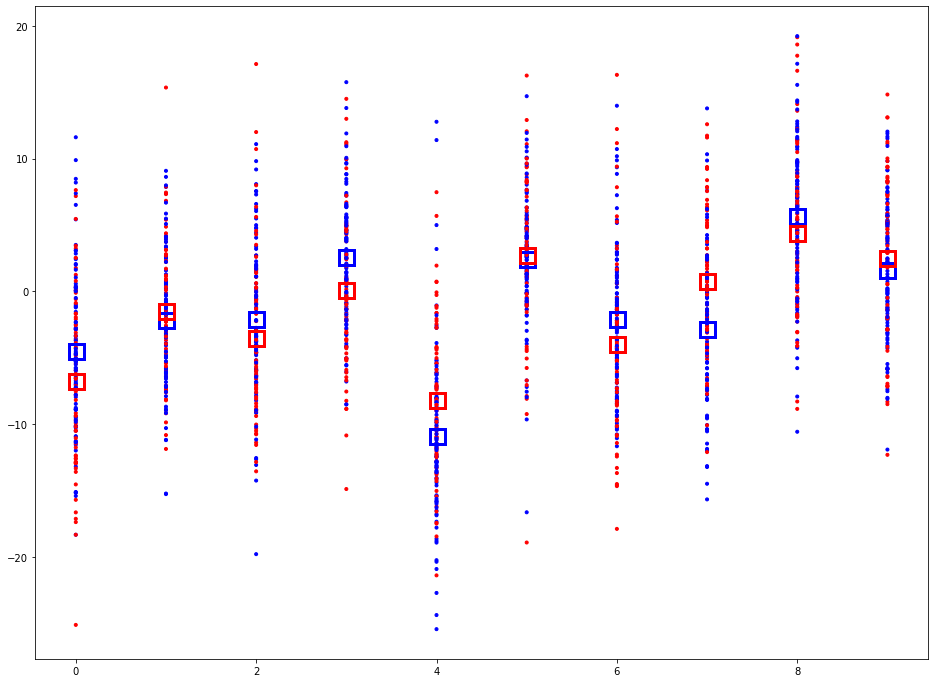

In [10]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False)

In [11]:
def do_pca(model_path, dataset=dataset_test):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = latent_df.shape[1]
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = pca.transform(label0_df)
    mean0 = np.mean(transformed0, axis=0)
    print(mean0.shape)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = pca.transform(label1_df)
    mean1 = np.mean(transformed1, axis=0)
    print(mean1.shape)

    idx = np.arange(n_components)+1
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

    limit_df = n_components

    #make scree plot
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    fig, axs = plt.subplots(1, 2, figsize=(30,10)) 
    [t.set_color('white') for t in axs[0].xaxis.get_ticklabels()]
    [t.set_color('white') for t in axs[0].yaxis.get_ticklabels()]
    axs[0].set_title('Explained variance across principal components', fontsize=14)
    axs[0].set_xlabel('Principal component', fontsize=12)
    axs[0].set_ylabel('Explained variance', fontsize=12)
    sns.barplot(ax=axs[0], x=idx[:limit_df], y='explained variance', data=df_explained_variance, palette='summer')
    axs[0] = axs[0].twinx()
    axs[0].grid(False)
    axs[0].set_ylabel('Cumulative', fontsize=14)
    sns.lineplot(ax=axs[0], x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance, color='#fc8d59')

    N, D = transformed.shape
    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs[1].scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs[1].scatter(x, transformed1, c='red', marker='.')
    x = np.arange(D)
    axs[1].plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)
    axs[1].plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()


In [12]:
def do_dictionary_learning(data_df, n_components=10, transform_n_nonzero_coefs=1):
    data_df_local = data_df.copy()
    full_df_local = pd.DataFrame()
    # Makes dictionary learning over all embeddings
    latent_df = data_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = n_components
    dict_learner = DictionaryLearning(n_components=n_components,
                                      transform_n_nonzero_coefs=transform_n_nonzero_coefs,
                                      alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = data_df_local.index
    full_df_local = pd.merge(data_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local, dict_learner

In [13]:
def plot_patterns(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Transforms over label0 dataframe
    label0_df = full_df_local[full_df_local['label'] == 0].iloc[:,1:]
    transformed0 = label0_df.values

    # Transforms over label1 dataframe
    label1_df = full_df_local[full_df_local['label'] == 1].iloc[:,1:]
    transformed1 = label1_df.values

    fig, axs = plt.subplots(1, 1, figsize=(10,7)) 

    _, D = transformed0.shape

    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs.scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs.scatter(x, transformed1, c='red', marker='.')

    x = np.arange(D)

    masked0 = np.ma.masked_equal(transformed0, 0.)
    mean0 = masked0.mean(axis=0)
    axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    masked1 = np.ma.masked_equal(transformed1, 0.)
    mean1 = masked1.mean(axis=0)
    axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()

In [14]:
def return_predictions(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res = np.zeros(2*n_patterns)

    # Makes random permutation to produce random label
    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)

    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df_local[full_df_local[c] < 0.]
        res[2*i] = df['label'].mean()
        df = full_df_local[full_df_local[c] > 0.]
        res[2*i+1] = df['label'].mean()

    return res

def plot_predictions(prediction_df, transformed_df):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_random = np.zeros((20, 2*n_patterns))

    # Loads labels
    mean_label = prediction_df_local['label'].mean()
    print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res = return_predictions(prediction_df_local, transformed_df_local)
    for i in range(20):
        res_random[i,:] = return_predictions(prediction_df_local, transformed_df_local, True)
    
    for i in range(20):
        plt.scatter(x, res_random[i], c='grey')

    plt.scatter(x, res, c='red')
    plt.plot(mean_label*np.ones(2*n_patterns))
    plt.ylim((0,1))
    return res   

In [15]:
def return_sum(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res_sum = np.zeros(2*n_patterns)
    res_len = np.zeros(2*n_patterns)

    full_df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df[full_df[c] < 0.]
        res_sum[2*i] = df['label'].sum()
        res_len[2*i] = len(df)
        df = full_df[full_df[c] > 0.]
        res_sum[2*i+1] = df['label'].sum()
        res_len[2*i+1] = len(df)

    return res_sum, res_len


def do_t_test(prediction_df, transformed_df, show=True, nb_components=10):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_p = np.zeros(2*n_patterns)

    # Mean labels
    mean_label = prediction_df_local['label'].mean()
    # print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res_sum, res_len = return_sum(prediction_df_local, transformed_df_local)
    print(res_len)
    
    for i in range(2*n_patterns):
        res_p[i] = binom_test(res_sum[i], n=res_len[i], p=mean_label, alternative='two-sided')

    if show:
        plt.scatter(x, -np.log10(res_p))
        plt.plot(-np.log10(0.05/(2*nb_components))*np.ones(2*n_patterns))

    return res_p   

In [16]:
def give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, show=True, nb_components=10):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)
    nb_subjects = np.zeros(len(res_p))
    nb_subjects_relevant = 0
    exact_nb_subjects_relevant = 0
    log_p_nb_subjects = 0
    max_auc_score = 0.0
    auc_score = np.zeros(len(res_p))
    accuracy = []
    # print(len(df.columns))
    for i in range(1,len(df.columns)):
        # print(df.iloc[:,[i]].columns)
        d = df[df.iloc[:,i] < 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        # print(np.unique(d.label.values).shape)
        nb_subjects[2*i-2] = len(d)
        auc_score[2*i-2] = accuracy_score(d.label, d.iloc[:,i])
        if 2.*d.label.sum() < (len(d.label)):
            exact_nb_subjects = len(d.label)-d.label.sum()
        else:
            exact_nb_subjects = d.label.sum()
        accuracy.append(float(exact_nb_subjects)/len(d.label))
        
        if res_p[2*i-2] < 0.05/nb_components:
            nb_subjects_relevant += nb_subjects[2*i-2]
            max_auc_score = max(auc_score[2*i-2], max_auc_score)
            exact_nb_subjects_relevant += exact_nb_subjects
            log_p_nb_subjects += -np.log10(res_p[2*i-2])*exact_nb_subjects

        d = df[df.iloc[:,i] > 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        nb_subjects[2*i-1] = len(d)
        auc_score[2*i-1] = accuracy_score(d.label, d.iloc[:,i])
        if 2.*d.label.sum() < (len(d.label)):
            exact_nb_subjects = len(d.label)-d.label.sum()
        else:
            exact_nb_subjects = d.label.sum()
        accuracy.append(float(exact_nb_subjects)/len(d.label))
        
        if res_p[2*i-1] < 0.05/nb_components:
            nb_subjects_relevant += nb_subjects[2*i-1]
            max_auc_score = max(auc_score[2*i-1], max_auc_score)
            exact_nb_subjects_relevant += exact_nb_subjects
            log_p_nb_subjects += -np.log10(res_p[2*i-2])*exact_nb_subjects
            
    # print(d)
    if show:
        x = np.arange(len(res_p))
        plt.scatter(x, auc_score)
        plt.ylabel('accuracy_score')
        # plt.scatter(res_p, auc_score)
        # plt.xlabel('p value')
        # plt.ylabel('auc_score')
    return accuracy, nb_subjects_relevant, max_auc_score, exact_nb_subjects_relevant, log_p_nb_subjects

In [17]:
def test_dictionary_learning(dict_learner, test_df, n_components):
    test_df_local = test_df.copy()
    full_df_local = pd.DataFrame()
    latent_df = test_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    transformed = dict_learner.transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = test_df_local.index
    full_df_local = pd.merge(test_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local


## Non-zeros=1, nb_components=4

In [18]:
full_df, transformed_train_df, dict_learner = do_dictionary_learning(data_df=train_df, n_components=4, transform_n_nonzero_coefs=1)

INFO:numexpr.utils: Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils: NumExpr defaulting to 8 threads.


In [19]:
full_df, transformed_df = test_dictionary_learning(dict_learner=dict_learner, test_df=test_df, n_components=4)

In [20]:
dict_learner.components_

array([[ 0.37143721, -0.17991308,  0.41912043,  0.44523598, -0.20192509,
        -0.23042552,  0.08564891, -0.37356087, -0.12785366, -0.44572299],
       [ 0.17798331,  0.51058245,  0.0906847 , -0.23757672,  0.08794359,
        -0.04999073, -0.22026144, -0.56386262, -0.31126185,  0.41156754],
       [-0.28849468,  0.44414687,  0.07404849,  0.0349497 ,  0.13541201,
        -0.71606466,  0.17044274,  0.35671261, -0.09441188, -0.12847757],
       [ 0.30646535,  0.12571711,  0.27791531, -0.53237956, -0.20366204,
        -0.09993035, -0.23805592,  0.23058075, -0.18783234, -0.57708395]])

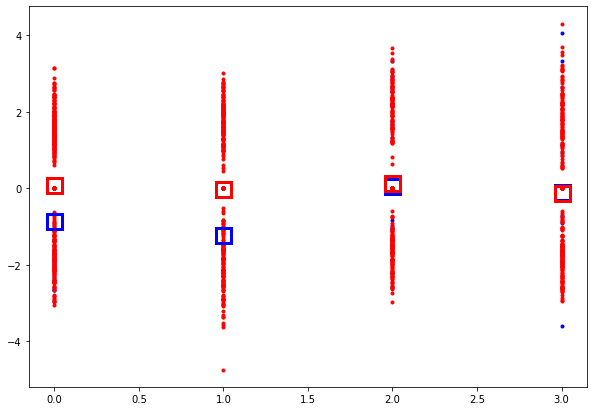

In [21]:
plot_patterns(prediction_df, transformed_df, random=False)

In [22]:
# plot_patterns(prediction_df, transformed_df, random=True)

In [23]:
def plot_patterns_separated(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    l = len(full_df_local)
    d = len(full_df_local.columns)
    res = pd.DataFrame(np.zeros((l,3)), index=full_df_local.index, columns=["val", "label", "pat"])
    patterns = ["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"]

    for index, row in transformed_df_local.iterrows():
        idx_nonzero = int(np.nonzero(row.values)[0])
        val_nonzero = row.iloc[idx_nonzero]
        res.loc[index, "val"] = np.abs(val_nonzero)
        res.loc[index, "label"] = prediction_df_local.loc[index, "label"]
        if val_nonzero < 0.:
            res.loc[index, "pat"] = patterns[2*idx_nonzero]
        else:
            res.loc[index, "pat"] = patterns[2*idx_nonzero+1]

    res.sort_values(ascending=True, by='pat', inplace=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    # g = sns.pointplot(data=res, x=res.pat, y="val", hue = "label", alpha=[0.5,0.5], palette=['blue', 'red'], markers=['v', 's'], scale=2, linestyles=['None', 'None'], ax=ax)
    # plt.setp(g.collections, alpha=0.5)
    # plt.setp(g.lines, alpha=.5) 
    sns.stripplot(data=res[res.label==0], x=res.pat, y="val", hue = "label", marker='v', palette=['blue'], size=5, jitter=.3, ax=ax)
    sns.stripplot(data=res[res.label==1], x=res.pat, y="val", hue = "label", marker='s', palette=['red'], size=5, jitter=.3, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[1], handles[0]], ["male", "female"], labelspacing=2)

    plt.show()

    return res

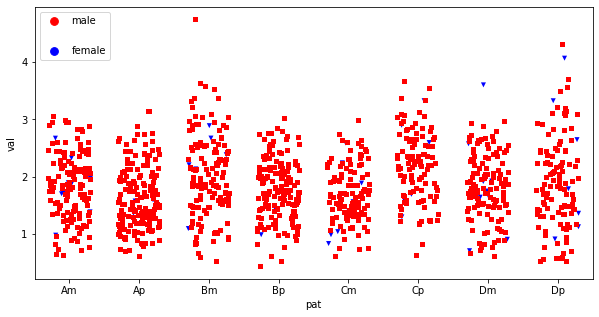

In [24]:
res_df = plot_patterns_separated(prediction_df, transformed_df)

In [25]:
res_df.head()

,val,label,pat
Subject,,,
sub-1090652,1.275529,1.0,Am
sub-1074148,0.707117,1.0,Am
sub-1121517,2.480574,1.0,Am
sub-1023009,2.817342,1.0,Am
sub-1169512,2.414491,1.0,Am


In [26]:
a = "ab"
a[0]

'a'

In [27]:
res_df2 = res_df.copy()
res_df2["atom"] = res_df2["pat"].apply(lambda x: x[0])
res_df2["sign"] = res_df2["pat"].apply(lambda x: x[1])
res_df2.rename(columns={"label": "gender"}, inplace=True)
res_df2.gender = res_df2.gender.apply(lambda x: "male" if x== 1.0 else "female")
# res_df2.sort_values(ascending=True, by='atom', inplace=True)
# res_df2.sort_values(ascending=False, by='sign', inplace=True)
res_df2 = res_df2.sort_values(['atom', 'sign'], ascending=[True, False])
res_df2.drop(columns="pat", inplace=True)

In [28]:
res_df2.head()

,val,gender,atom,sign
Subject,,,,
sub-1060695,1.884088,male,A,p
sub-1062473,1.143408,male,A,p
sub-1063062,1.262061,male,A,p
sub-1060820,3.129864,male,A,p
sub-1147515,1.135125,male,A,p


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


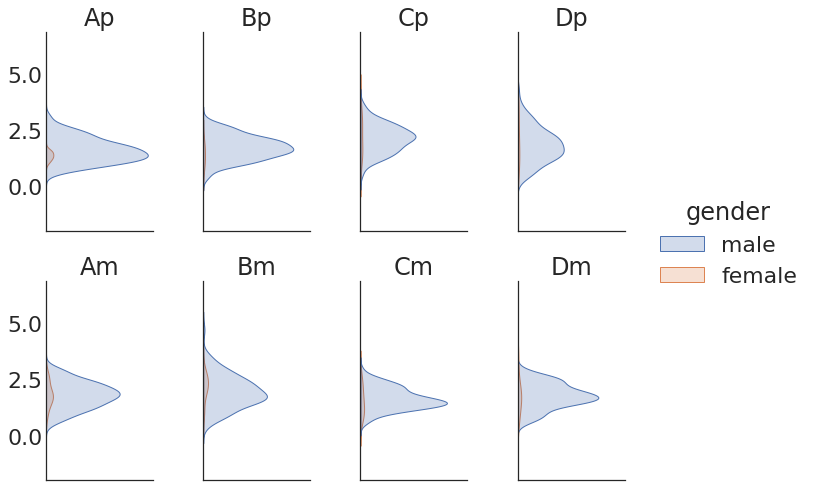

In [29]:
sns.set(font_scale=2)
print(plt.style.available)
plt.style.use('seaborn-white')
g = sns.displot(
    data=res_df2, y="val", hue="gender", col="atom", row="sign",
    fill=True,
    kind="kde", height=4, aspect=.6,
)
g.set_axis_labels("", "")
g.set_titles("{col_name}{row_name}", loc='center')
g.set(xticklabels=[])
# plt.setp(g._legend.get_title(), fontsize=30)

In [30]:
def plot_patterns_separated_without_labels(transformed_df, random=False):
    # Makes local copy
    transformed_df_local = transformed_df.copy()
    full_df_local = transformed_df_local

    l = len(full_df_local)
    d = len(full_df_local.columns)
    res = pd.DataFrame(np.zeros((l,3)), index=full_df_local.index, columns=["val", "label", "pat"])
    patterns = ["Ap", "Am", "Bp", "Bm", "Cp", "Cm", "Dp", "Dm"]

    for index, row in transformed_df_local.iterrows():
        idx_nonzero = int(np.nonzero(row.values)[0])
        val_nonzero = row.iloc[idx_nonzero]
        res.loc[index, "val"] = np.abs(val_nonzero)
        res.loc[index, "label"] = 0
        if val_nonzero > 0.:
            res.loc[index, "pat"] = patterns[2*idx_nonzero]
        else:
            res.loc[index, "pat"] = patterns[2*idx_nonzero+1]

    res.sort_values(ascending=True, by='pat', inplace=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    g = sns.pointplot(data=res, x=res.pat, y="val", hue = "label", alpha=[0.5,0.5], palette=['blue', 'red'], markers=['v', 's'], scale=2, linestyles=['None', 'None'], ax=ax)
    plt.setp(g.collections, alpha=0.5)
    # plt.setp(g.lines, alpha=.5) 
    sns.stripplot(data=res[res.label==0], x=res.pat, y="val", hue = "label", marker='v', palette=['blue'], jitter=.1, ax=ax)
    # sns.stripplot(data=res[res.label==1], x=res.pat, y="val", hue = "label", marker='s', palette=['red'], jitter=.1, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([],[], frameon=False)
    
    plt.show()

    return res

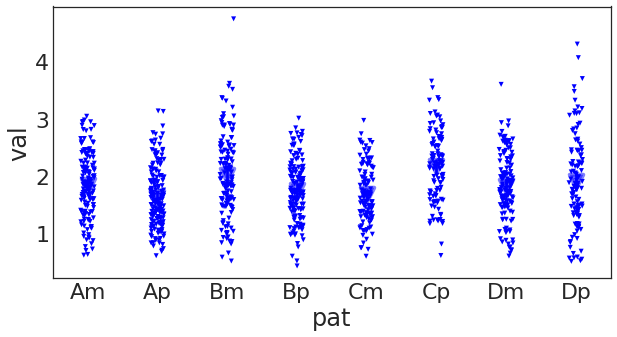

In [31]:
res_train_df = plot_patterns_separated_without_labels(transformed_train_df)

In [32]:
def plotting_hist(res_df):
    patterns = ["Ap", "Am", "Bp", "Bm", "Cp", "Cm", "Dp", "Dm"]

    plt.rc('axes', labelsize=14) 
    f, axs = plt.subplots(4, 2, figsize=(11, 22))

    for i, pat in enumerate(patterns):
        axs[i%4,int(i/4)].hist(res_df[(res_df.label==0) & (res_df.pat==pat)].val, alpha=0.5)
        axs[i%4,int(i/4)].hist(res_df[(res_df.label==1) & (res_df.pat==pat)].val, alpha=0.5)

In [33]:
# res0_df = res_df.copy()
# res0_df.label=0
# plotting_hist(res0_df)

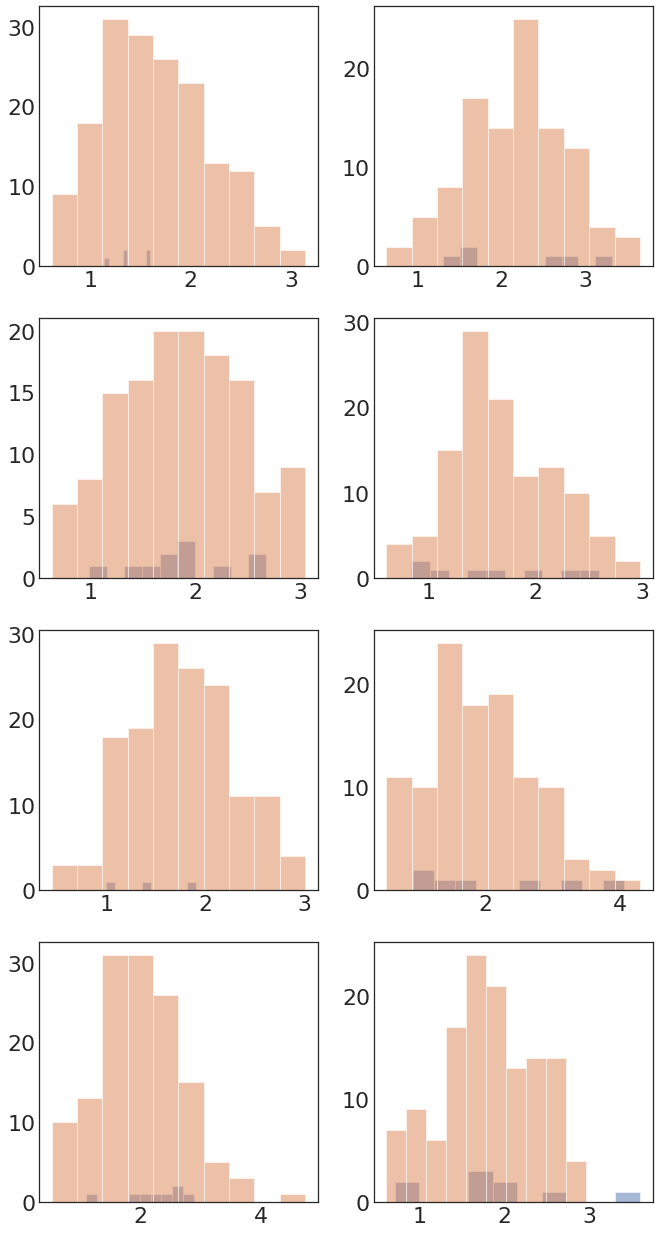

In [34]:
plotting_hist(res_df)

In [35]:
# plotting_hist(res_train_df)

Mean label = 0.9482288828337875


array([0.92465753, 0.97109827, 0.94405594, 0.98013245, 0.93548387,
       0.94545455, 0.93478261, 0.93965517])

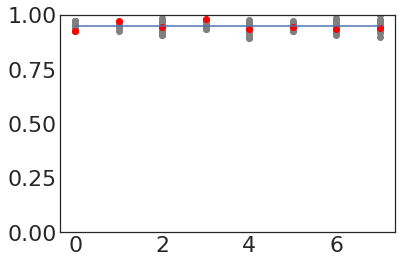

In [36]:
plot_predictions(prediction_df, transformed_df)

[146. 173. 143. 151. 124. 110. 138. 116.]


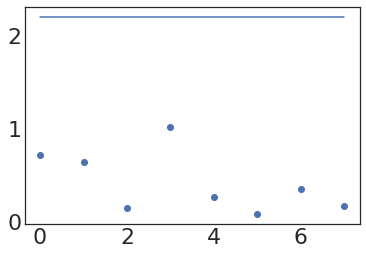

In [37]:
res_p = do_t_test(prediction_df, transformed_df, nb_components=4)

([0.9246575342465754, 0.9710982658959537, 0.9440559440559441, 0.9801324503311258, 0.9354838709677419, 0.9454545454545454, 0.9347826086956522, 0.9396551724137931], 0, 0.0, 0, 0)


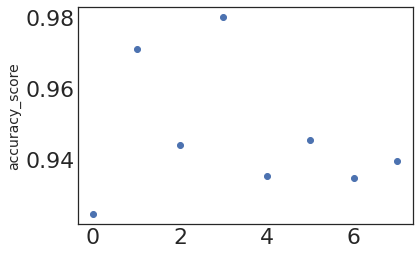

In [38]:
ret_nb_subjects = give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, nb_components=4)
print(ret_nb_subjects)
accuracy = ret_nb_subjects[0]

In [39]:
transformed_df.head()

,trans_0,trans_1,trans_2,trans_3
ID,,,,
sub-1000021,0.000000,-2.534987,0.000000,0.000000
sub-1000458,0.000000,0.000000,-1.044364,0.000000
sub-1000575,0.000000,0.000000,0.000000,-3.601568
sub-1000606,0.000000,0.000000,3.326317,0.000000
sub-1000963,-1.971037,0.000000,0.000000,0.000000


In [40]:
def plot_manhattan(prediction_df, transformed_df, accuracy, ax):
    labelsize=16
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    nb_components = 2*len(transformed_df.columns)
    res_p = do_t_test(prediction_df,
                      transformed_df,
                      show=False,
                      nb_components=nb_components)
    print(res_p)
    
    markerline, stemlines, baseline = \
        ax.stem(["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"],
              -np.log10(res_p),
              basefmt= 'C0',
              linefmt=':')
    plt.setp(markerline, 'color', 'black')
    plt.setp(stemlines, 'color', 'black')
    plt.setp(baseline, 'color', 'black')
    ax.plot(-np.log10(0.05/(nb_components))*np.ones(nb_components), c='black')
    ax.set_ylabel("-log$_{10}$(p)", labelpad=5.0)
    ax.set_xlabel("folding atoms", labelpad=10.0)
    ax2 = ax.twinx()
    ax2.xaxis.set_tick_params(labelsize = labelsize)
    ax2.yaxis.set_tick_params(labelsize = labelsize)
    ax2.plot(["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"],accuracy, c='blue')
    print(accuracy)
    ax2.set_ylim([0.,1.38])
    ax2.set_ylabel('accuracy', color='b', rotation=270, labelpad=25)
    ax2.set_yticks([0., 0.5, 1.0])
    ax2.spines['right'].set_color('blue')
    ax2.tick_params(axis='y', colors='blue')
    ax2.set_ylim(-0.08)


[146. 173. 143. 151. 124. 110. 138. 116.]
[0.1895903  0.2271895  0.70769864 0.09452652 0.53862477 0.8285755
 0.43994958 0.67176491]
[0.9246575342465754, 0.9710982658959537, 0.9440559440559441, 0.9801324503311258, 0.9354838709677419, 0.9454545454545454, 0.9347826086956522, 0.9396551724137931]


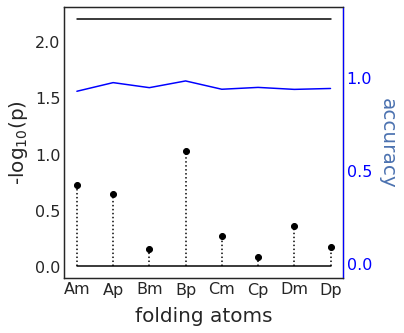

In [41]:
plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_manhattan(prediction_df, transformed_df, accuracy, ax)
plt.show()

In [42]:
len(transformed_df)

1101

## Visualize umap

In [43]:
def compute_umap(df):
    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [44]:
def display_umaps_true_labels(visual_embs_train, reducer, test_df, prediction_df, verbose=False):
    if verbose:
        print("Test df:")
        print(test_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    if verbose:
        print("UMAP embeddings")
        print(visual_embs_train.shape)
        print(visual_embs_train[:5])
    visual_embs_test = reducer.transform(test_df)

    ## plot the graphs

    plt.figure()
    plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c='green', alpha=0.1)

    # plot for true labels
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs_test[:,0], visual_embs_test[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    plt.show()

    return pd.DataFrame(visual_embs_test, index=test_df.index.values)

In [45]:
test_df.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10
ID,,,,,,,,,,
sub-1000021,-11.076599,-0.057593,-0.504946,13.787149,-5.623165,-14.787987,-6.232753,15.323562,10.418938,-11.061039
sub-1000458,9.511126,0.128145,4.478190,3.851680,7.315600,7.109017,-11.019066,-1.318156,1.013753,-4.718795
sub-1000575,-17.447617,-4.579598,-10.238689,14.008757,5.279231,-0.996235,9.278101,0.155234,0.313623,15.755119
sub-1000606,0.840568,15.780238,-9.238461,-0.624602,-5.837038,-27.161884,12.402494,8.603508,13.773623,-3.677515
sub-1000963,-8.784658,1.427981,-2.758444,-6.381388,-0.388595,13.868286,-14.848114,3.806087,4.268200,5.453033


In [46]:
visual_embs, reducer = compute_umap(test_df)

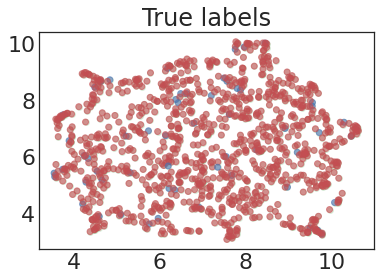

In [47]:
df_umap = display_umaps_true_labels(visual_embs, reducer, test_df, prediction_df, verbose=False)

In [48]:
transformed_df.head()

,trans_0,trans_1,trans_2,trans_3
ID,,,,
sub-1000021,0.000000,-2.534987,0.000000,0.000000
sub-1000458,0.000000,0.000000,-1.044364,0.000000
sub-1000575,0.000000,0.000000,0.000000,-3.601568
sub-1000606,0.000000,0.000000,3.326317,0.000000
sub-1000963,-1.971037,0.000000,0.000000,0.000000


In [49]:
transformed_df2 = transformed_df.copy()

In [50]:
transformed_df2["label"] = transformed_df.trans_1.apply(lambda x: 1 if x < 0. else 0)

In [51]:
transformed_df2.head()

,trans_0,trans_1,trans_2,trans_3,label
ID,,,,,
sub-1000021,0.000000,-2.534987,0.000000,0.000000,1
sub-1000458,0.000000,0.000000,-1.044364,0.000000,0
sub-1000575,0.000000,0.000000,0.000000,-3.601568,0
sub-1000606,0.000000,0.000000,3.326317,0.000000,0
sub-1000963,-1.971037,0.000000,0.000000,0.000000,0


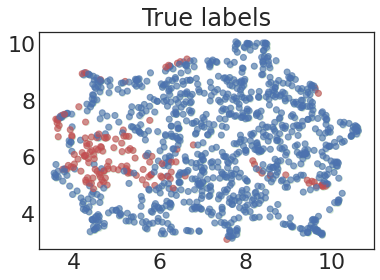

In [52]:
df_umap = display_umaps_true_labels(visual_embs, reducer, test_df, transformed_df2, verbose=False)

## Correspondance des sujets ACCpatterns

In [53]:
transformed_df2[transformed_df2.label==1].index

Index(['sub-1000021', 'sub-1002584', 'sub-1003425', 'sub-1004170',
       'sub-1007047', 'sub-1007175', 'sub-1009695', 'sub-1010381',
       'sub-1012655', 'sub-1016339',
       ...
       'sub-1243495', 'sub-1244542', 'sub-1245864', 'sub-1246694',
       'sub-1249508', 'sub-1251127', 'sub-1251211', 'sub-1257564',
       'sub-1259076', 'sub-1260994'],
      dtype='object', name='ID', length=143)

In [54]:
transformed_df2[transformed_df2.label==1]

,trans_0,trans_1,trans_2,trans_3,label
ID,,,,,
sub-1000021,0.0,-2.534987,0.0,0.0,1
sub-1002584,0.0,-2.674469,0.0,0.0,1
sub-1003425,0.0,-2.890704,0.0,0.0,1
sub-1004170,0.0,-2.209138,0.0,0.0,1
sub-1007047,0.0,-1.098214,0.0,0.0,1
...,...,...,...,...,...
sub-1251127,0.0,-4.743010,0.0,0.0,1
sub-1251211,0.0,-1.625845,0.0,0.0,1
sub-1257564,0.0,-2.325036,0.0,0.0,1


In [55]:
prediction_df[transformed_df2.label==1]

,label,svm_0,svm_1,svm_2,svm_3,svm_4,svm_5,svm_6,svm_7,svm_8,...,svm_243,svm_244,svm_245,svm_246,svm_247,svm_248,svm_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
sub-1000021,0,0.948965,0.948382,0.949156,0.947968,0.949186,0.949133,0.948409,0.949833,0.950552,...,0.949805,0.948885,0.949294,0.949522,0.949724,0.948059,0.950234,0.948938,0.949238,0.951779
sub-1002584,0,0.948936,0.948793,0.949063,0.948334,0.949009,0.949028,0.948626,0.949484,0.950046,...,0.949582,0.948884,0.949139,0.949274,0.950242,0.948445,0.949906,0.948959,0.949242,0.951137
sub-1003425,0,0.949905,0.949764,0.949079,0.949371,0.949280,0.948379,0.948147,0.950009,0.950402,...,0.949187,0.950437,0.948811,0.949629,0.950447,0.948461,0.948800,0.949416,0.949880,0.948257
sub-1004170,0,0.949980,0.949825,0.949089,0.949401,0.949306,0.948320,0.948076,0.950049,0.950496,...,0.949204,0.950567,0.948796,0.949668,0.950557,0.948416,0.948764,0.949450,0.949914,0.948164
sub-1007047,0,0.950020,0.947630,0.947335,0.948591,0.946436,0.947355,0.952772,0.947657,0.947352,...,0.946964,0.948279,0.947498,0.948232,0.947144,0.949027,0.947583,0.948035,0.948440,0.949268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-1251127,1,0.947573,0.948416,0.948349,0.947790,0.950085,0.947758,0.948066,0.948096,0.947923,...,0.948681,0.948671,0.947697,0.947795,0.947815,0.947469,0.948625,0.947945,0.948240,0.948975
sub-1251211,1,0.948057,0.947483,0.949223,0.947833,0.948892,0.947951,0.947573,0.947697,0.947735,...,0.947845,0.949966,0.947973,0.947889,0.948038,0.947939,0.950253,0.947943,0.948364,0.947835
sub-1257564,1,0.947875,0.947838,0.948894,0.947817,0.949347,0.947878,0.947760,0.947848,0.947806,...,0.948162,0.949481,0.947869,0.947854,0.947954,0.947762,0.949643,0.947962,0.948319,0.948269


In [56]:
prediction_df[transformed_df2.trans_1 > 0.]

,label,svm_0,svm_1,svm_2,svm_3,svm_4,svm_5,svm_6,svm_7,svm_8,...,svm_243,svm_244,svm_245,svm_246,svm_247,svm_248,svm_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
sub-1001444,0,0.948942,0.948706,0.949082,0.948257,0.949047,0.949050,0.948580,0.949558,0.950153,...,0.949629,0.948884,0.949172,0.949327,0.950133,0.948363,0.949976,0.948963,0.949241,0.951273
sub-1009294,0,0.948494,0.946622,0.950004,0.947873,0.947785,0.948125,0.947122,0.947332,0.947563,...,0.947073,0.951116,0.948223,0.947975,0.948240,0.948364,0.951690,0.947977,0.948465,0.946779
sub-1009460,0,0.947955,0.947683,0.949039,0.947824,0.949148,0.947910,0.947678,0.947782,0.947775,...,0.948023,0.949694,0.947915,0.947869,0.947991,0.947840,0.949911,0.947966,0.948339,0.948079
sub-1014195,1,0.948957,0.948493,0.949131,0.948067,0.949138,0.949105,0.948468,0.949739,0.950415,...,0.949744,0.948885,0.949252,0.949455,0.949865,0.948163,0.950146,0.948937,0.949239,0.951606
sub-1014388,1,0.948855,0.949936,0.948797,0.949354,0.948507,0.948731,0.949233,0.948485,0.948594,...,0.948949,0.948879,0.948698,0.948567,0.951675,0.949519,0.948970,0.949010,0.949241,0.949283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-1247321,1,0.948325,0.946957,0.949703,0.947858,0.948216,0.948058,0.947297,0.947474,0.947630,...,0.947373,0.950675,0.948127,0.947942,0.948162,0.948200,0.951139,0.947997,0.948428,0.947190
sub-1248002,1,0.948357,0.946893,0.949761,0.947860,0.948134,0.948071,0.947263,0.947447,0.947617,...,0.947316,0.950759,0.948145,0.947949,0.948177,0.948231,0.951245,0.948002,0.948435,0.947112
sub-1248037,1,0.948430,0.946748,0.949891,0.947867,0.947948,0.948100,0.947188,0.947386,0.947588,...,0.947186,0.950951,0.948187,0.947963,0.948211,0.948302,0.951483,0.947966,0.948451,0.946934
